In [4]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import re
import os
import time

# 👉 전체 데이터 저장 리스트 (타격 + 투구)
all_team_totals = []

# 👉 열 이름 정의 (미리)
columns = (
    ['GameID', 'Team'] +
    ['PA', 'AB', 'R', 'H', 'HR', 'RBI', 'BB', 'HBP', 'SO',
     'GO', 'FO', 'NP', 'GDP', 'LOB', 'AVG', 'OPS', 'LI_b', 'WPA_b', 'RE24_b'] +
    ['IP', 'TBF', 'H_p', 'R_p', 'ER', 'BB_p', 'HBP_p', 'K', 'HR_p',
     'GO-FO', 'NP-S', 'IR-IS', 'GSC', 'ERA', 'WHIP', 'LI_p', 'WPA_p', 'RE24_p']
)

# 👉 CSV 파일명
csv_file = '현빈-2024_total.csv'

# 👉 기존 파일이 있으면 불러오기
if os.path.exists(csv_file):
    existing_df = pd.read_csv(csv_file)
    print(f"기존 {csv_file} 불러옴, {len(existing_df)}개의 행이 존재함")
else:
    existing_df = pd.DataFrame(columns=columns)

# 👉 날짜 반복
for num in range(1357, 1357):
    game_id = f"2024{num:04d}"
    time.sleep(15)

    try:
        url = f'https://statiz.sporki.com/schedule/?m=boxscore&s_no={game_id}'
        headers = {'User-Agent': 'Mozilla/5.0'}
        res = requests.get(url, headers=headers)
        res.raise_for_status()
        soup = BeautifulSoup(res.text, 'html.parser')

        # 👉 타격 기록 저장용 임시 딕셔너리 (team_name → 타격 데이터)
        batting_dict = {}

        # ✅ 타격 기록
        batting_sections = soup.select('div.box_type_boared .item_box')
        for section in batting_sections:
            head = section.select_one('.box_head')
            if head and '타격기록' in head.text:
                team_name_raw = head.text.replace('타격기록', '').strip()
                team_name = re.sub(r'[()]', '', team_name_raw)
                total_row = section.select_one('tr.total')
                if total_row:
                    values = [td.text.strip() for td in total_row.find_all('td') if not td.has_attr('colspan')]
                    if len(values) == 19:
                        batting_dict[team_name] = values

        # ✅ 투구 기록
        pitching_tables = soup.select('div.box_type_boared .box_head')
        for head in pitching_tables:
            if '투구기록' in head.text:
                team_name_raw = head.text.replace('투구기록', '').strip()
                team_name = re.sub(r'[()]', '', team_name_raw)
                total_row = head.find_next('tr', class_='total')
                tds = total_row.find_all('td')

                if len(tds) >= 19:
                    pitching_values = [td.text.strip() for td in tds[1:]]
                    if team_name in batting_dict:
                        batting_values = batting_dict[team_name]
                        # 날짜 정보 추출
                        score_box = soup.select_one('div.callout_box div.score .txt')
                        if score_box:
                            full_text = score_box.text.strip()  # 예: "고척, 04-03"
                            if ',' in full_text:
                                date_part = full_text.split(',')[-1].strip()  # "04-03"
                        all_team_totals.append([date_part, team_name] + batting_values + pitching_values)

    except Exception as e:
        print(f"❌ 오류 발생: {game_id} - {e}")

        # 👉 지금까지 수집된 데이터 저장 후 종료
        if all_team_totals:
            new_df = pd.DataFrame(all_team_totals, columns=columns)
            combined_df = pd.concat([existing_df, new_df], ignore_index=True)
            combined_df.to_csv(csv_file, index=False, encoding='utf-8-sig')
            print(f"✅ 오류 직전까지 {len(all_team_totals)}건 저장 완료")
        else:
            print("⛔ 저장할 데이터 없음")
        break

# 👉 전체 루프 완료 후 저장
if all_team_totals:
    new_df = pd.DataFrame(all_team_totals, columns=columns)
    combined_df = pd.concat([existing_df, new_df], ignore_index=True)
    combined_df.to_csv(csv_file, index=False, encoding='utf-8-sig')
    print(f"🎉 전체 완료! 총 {len(combined_df)}건 저장됨. {num}까지 완료 다음 번 {num+1}부터 시작")


기존 현빈-2024_total.csv 불러옴, 72개의 행이 존재함


In [4]:
import pandas as pd

def preprocess_baseball_data_and_save(file_paths, output_path):
    # 여러 csv 파일을 읽어 하나의 DataFrame으로 합침
    df_total = pd.concat([pd.read_csv(fp) for fp in file_paths], ignore_index=True)

    # 각 파일에서 연도 추출하여 GameID에 붙이기
    for fp in file_paths:
        year = fp.split('_')[0]
        mask = df_total['GameID'].isin(pd.read_csv(fp)['GameID'])
        df_total.loc[mask, 'GameID'] = year + '-' + df_total.loc[mask, 'GameID']

    # 날짜 변환 및 정렬
    df_total['GameDate'] = pd.to_datetime(df_total['GameID'])
    df_total = df_total.sort_values('GameDate').reset_index(drop=True)

    # 문자열 분할하여 숫자형 컬럼으로
    df_total[['GO', 'FO']] = df_total['GO-FO'].str.split('-', expand=True).astype(int)
    df_total[['NP_total', 'NP_strike']] = df_total['NP-S'].str.split('-', expand=True).astype(int)
    df_total[['IR', 'IS']] = df_total['IR-IS'].str.split('-', expand=True).astype(int)
    df_total.drop(columns=['GO-FO', 'NP-S', 'IR-IS'], inplace=True)

    # 팀 One-Hot Encoding
    df_total = pd.get_dummies(df_total, columns=['Team'])

    # 승/패/무승부 결과 생성
    results = []
    for i in range(0, len(df_total), 2):
        r1 = df_total.loc[i, 'R']
        r2 = df_total.loc[i+1, 'R']
        if r1 > r2:
            results.extend([1, 0])
        elif r1 < r2:
            results.extend([0, 1])
        else:
            results.extend([-1, -1])
    df_total['Result'] = results

    # Team_ 컬럼의 bool 값을 1/0으로 변환
    team_cols = [col for col in df_total.columns if col.startswith("Team_")]
    df_total[team_cols] = df_total[team_cols].astype(int)

    # GameID 열 제거, GameDate를 맨 앞으로 이동
    df_total.drop(columns=['GameID'], inplace=True)
    cols = ['GameDate'] + [col for col in df_total.columns if col != 'GameDate']
    df_total = df_total[cols]

    # 전처리된 결과 저장
    df_total.to_csv(output_path, index=False, encoding='utf-8-sig')
    print(f"✅ 저장 완료: {output_path}")

# 사용 예시
file_paths = ['2024_total.txt']
output_path = 'processed_baseball_2024.csv'
preprocess_baseball_data_and_save(file_paths, output_path)

FileNotFoundError: [Errno 2] No such file or directory: '2024_total.txt'

In [3]:
import pandas as pd
import re
import os

def extract_year_from_filename(filepath):
    basename = os.path.basename(filepath)  # 경로에서 파일명만 추출
    match = re.match(r'(\d{4})_', basename)  # '2024_' 형식에만 일치
    if match:
        return match.group(1)
    else:
        raise ValueError(f"파일명에서 연도를 찾을 수 없습니다: {filepath}")
    

# GameID를 날짜 문자열로 변환 ('03월 23일' + '2024' → '2024-03-23')
def convert_korean_gameid_to_date(gameid, year):
    match = re.match(r'0?(\d{1,2})월 0?(\d{1,2})일', str(gameid))
    if match:
        return f"{year}-{int(match.group(1)):02}-{int(match.group(2)):02}"
    return None

# '09월 13일' 같은 날짜를 '9-13' 형식으로 변환
def convert_korean_date_to_numeric(value):
    match = re.match(r'0?(\d{1,2})월 0?(\d{1,2})일', str(value))
    if match:
        return f"{int(match.group(1))}-{int(match.group(2))}"
    return value

# 엑셀에서 망가진 값 예외 처리 ('Oct-85' → '10-13')
def fix_common_garbage_gofo(val):
    if val == 'Oct-85':
        return '10-13'
    return val

# 'x-y' 형식을 안전하게 정수 쌍으로 분리
def safe_split_to_int_pair(val):
    try:
        parts = str(val).split('-')
        if len(parts) == 2 and parts[0].isdigit() and parts[1].isdigit():
            return int(parts[0]), int(parts[1])
    except:
        pass
    return None, None

# 전체 전처리 함수
def preprocess_baseball_data_and_save(file_paths, output_path):
    combined = []

    for fp in file_paths:
        year = extract_year_from_filename(fp)  # 연도 추출
        df = pd.read_csv(fp, encoding='utf-16', sep='\t')
        df['GameDate'] = df['GameID'].apply(lambda x: convert_korean_gameid_to_date(x, year))
        combined.append(df)

        # GameID → GameDate 변환
        df['GameDate'] = df['GameID'].apply(lambda x: convert_korean_gameid_to_date(x, year))
        combined.append(df)

    df_total = pd.concat(combined, ignore_index=True)
    df_total['GameDate'] = pd.to_datetime(df_total['GameDate'], errors='coerce')
    #df_total = df_total.sort_values('GameDate').reset_index(drop=True)

    # 날짜형식 처리 + 잘못된 값 보정
    for col in ['GO-FO', 'NP-S', 'IR-IS']:
        df_total[col] = df_total[col].apply(convert_korean_date_to_numeric)
        df_total[col] = df_total[col].apply(fix_common_garbage_gofo)

    # 문자열 쌍 → 숫자형 컬럼으로 분리
    df_total[['GO', 'FO']] = df_total['GO-FO'].apply(lambda x: pd.Series(safe_split_to_int_pair(x)))
    df_total[['NP_total', 'NP_strike']] = df_total['NP-S'].apply(lambda x: pd.Series(safe_split_to_int_pair(x)))
    df_total[['IR', 'IS']] = df_total['IR-IS'].apply(lambda x: pd.Series(safe_split_to_int_pair(x)))
    df_total.drop(columns=['GO-FO', 'NP-S', 'IR-IS'], inplace=True)

    # 승/패/무 결과 계산
    results = []
    home_away = []

    for i in range(0, len(df_total), 2):
        r1 = df_total.loc[i, 'R']
        r2 = df_total.loc[i+1, 'R']
        if r1 > r2:
            results.extend([1, 0])
        elif r1 < r2:
            results.extend([0, 1])
        else:
            results.extend([-1, -1])
        home_away.extend([0,1])
    df_total['Result'] = results
    df_total['home_away'] = home_away


    # 무승부 제거 (두 줄 모두 제거)
    draw_indices = df_total[df_total['Result'] == -1].index
    paired_draw_indices = draw_indices.union(draw_indices + (-1) ** (draw_indices % 2 == 0))
    df_total = df_total.drop(paired_draw_indices).reset_index(drop=True)


    # GameID 제거, GameDate를 앞으로 이동
    df_total.drop(columns=['GameID'], inplace=True)
    cols = ['GameDate'] + [col for col in df_total.columns if col != 'GameDate']
    df_total = df_total[cols]

    
    df_total['Team'].replace('KIA',0,inplace = True)
    df_total['Team'].replace('두산',1,inplace = True)
    df_total['Team'].replace('삼성',2,inplace = True)
    df_total['Team'].replace('키움',3,inplace = True)
    df_total['Team'].replace('롯데',4,inplace = True)
    df_total['Team'].replace('SSG',5,inplace = True)
    df_total['Team'].replace('한화',6,inplace = True)
    df_total['Team'].replace('KT',7,inplace = True)
    df_total['Team'].replace('LG',8,inplace = True)
    df_total['Team'].replace('NC',9,inplace = True)

    # CSV로 저장 (한글 깨짐 방지용 utf-8-sig)
    df_total.to_csv(output_path, index=False, encoding='utf-8-sig')
    print(f"✅ 저장 완료: {output_path}")



# 사용 예시
file_paths = ['2023_total.csv']
output_path = 'processed_baseball_2023.csv'
preprocess_baseball_data_and_save(file_paths, output_path)


✅ 저장 완료: processed_baseball_2023.csv


C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_14872\448309069.py:103: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_total['Team'].replace('KIA',0,inplace = True)
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_14872\448309069.py:104: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always b

In [4]:
import pandas as pd
import re
import os

def preprocess_baseball_data_and_save(file_paths, output_path):
    # 여러 csv 파일을 읽어 하나의 DataFrame으로 합침
    df_total = pd.concat([pd.read_csv(fp) for fp in file_paths], ignore_index=True)

    df_total.to_csv(output_path, index=False, encoding='utf-8-sig')
    print(f"✅ 저장 완료: {output_path}")

# 사용 예시
file_paths = ['processed_2122.csv', 'processed_baseball_2023.csv', 'processed_2425.csv']  # 또는 실제 경로로 변경
output_path = 'processed_baseball_total.csv'
preprocess_baseball_data_and_save(file_paths, output_path)

✅ 저장 완료: processed_baseball_total.csv


In [10]:
import pandas as pd

def preprocess_and_save_rolling_only(file_paths, output_path):
    # 파일 합치기
    df_total = pd.concat([pd.read_csv(fp) for fp in file_paths], ignore_index=True)

    # 최근 5경기 승/패 전적 계산
    recent_wins = []
    recent_losses = []
    match_history = {}

    for i in range(0, len(df_total), 2):
        row1 = df_total.iloc[i]
        row2 = df_total.iloc[i + 1]

        t1, t2 = row1['Team'], row2['Team']
        key = tuple(sorted((t1, t2)))

        history = match_history.get(key, [])
        wins_t1 = history.count((t1, 1))
        wins_t2 = history.count((t2, 1))

        recent_wins.extend([wins_t1, wins_t2])
        recent_losses.extend([wins_t2, wins_t1])

        if row1['Result'] == 1:
            history.append((t1, 1))
        elif row2['Result'] == 1:
            history.append((t2, 1))

        match_history[key] = history[-5:]

    df_total['Recent_5_Win'] = recent_wins
    df_total['Recent_5_Loss'] = recent_losses

    # 수치형 컬럼에서 제외할 항목
    numeric_cols = df_total.select_dtypes(include='number').columns.tolist()
    exclude_cols = ['home_away', 'Recent_5_Win', 'Recent_5_Loss', 'WPA_p', 'RE24_p', 'WPA_b', 'RE24_b', 'AVG', 'OPS', 'GDP', 'LOB', 'GSC', 'LI_b', 'LI_p', 'IR', 'IS', 'HBP', 'HBP_p'] # 여기에 제외할 열 이름 적으면 됨
    rolling_cols = [col for col in numeric_cols if col not in exclude_cols]

    # 팀별 rolling 평균
    df_rolled = (
        df_total.groupby('Team')[rolling_cols]
        .rolling(window=5, min_periods=1)
        .mean()
        .reset_index(level=0, drop=True)
    )

    df_rolled.columns = [f"{col}" for col in df_rolled.columns]

    # 필요한 컬럼만 포함
    df_base = df_total[['GameDate', 'Team', 'Recent_5_Win', 'Recent_5_Loss']].copy()
    non_rolling_cols = df_total[exclude_cols]

    # 2. rolling 결과와 함께 병합
    df_result = pd.concat([
        df_base.reset_index(drop=True),
        non_rolling_cols.reset_index(drop=True),
        df_rolled.reset_index(drop=True)
    ], axis=1)

    
    # 컬럼 순서 맞추기
    desired_order = [
        'GameDate', 'Team', 'PA', 'AB', 'R', 'H', 'HR', 'RBI', 'BB', 'HBP', 'SO',
        'GO', 'FO', 'NP', 'GDP', 'LOB', 'AVG', 'OPS', 'LI_b', 'WPA_b', 'RE24_b',
        'IP', 'TBF', 'H_p', 'R_p', 'ER', 'BB_p', 'HBP_p', 'K', 'HR_p', 'GSC',
        'ERA', 'WHIP', 'LI_p', 'WPA_p', 'RE24_p', 'NP_total', 'NP_strike',
        'IR', 'IS', 'Result', 'home_away'
    ]
    df_result = df_result[[col for col in desired_order if col in df_result.columns]]

    
    # CSV로 저장
    df_result.to_csv(output_path, index=False, encoding='utf-8-sig')
    print(f"✅ 저장 완료: {output_path}")

# 사용 예시
file_paths = ['../data/concat_data.csv']
output_path = '../data/rolling_only.csv'
preprocess_and_save_rolling_only(file_paths, output_path)


✅ 저장 완료: ../data/rolling_only.csv


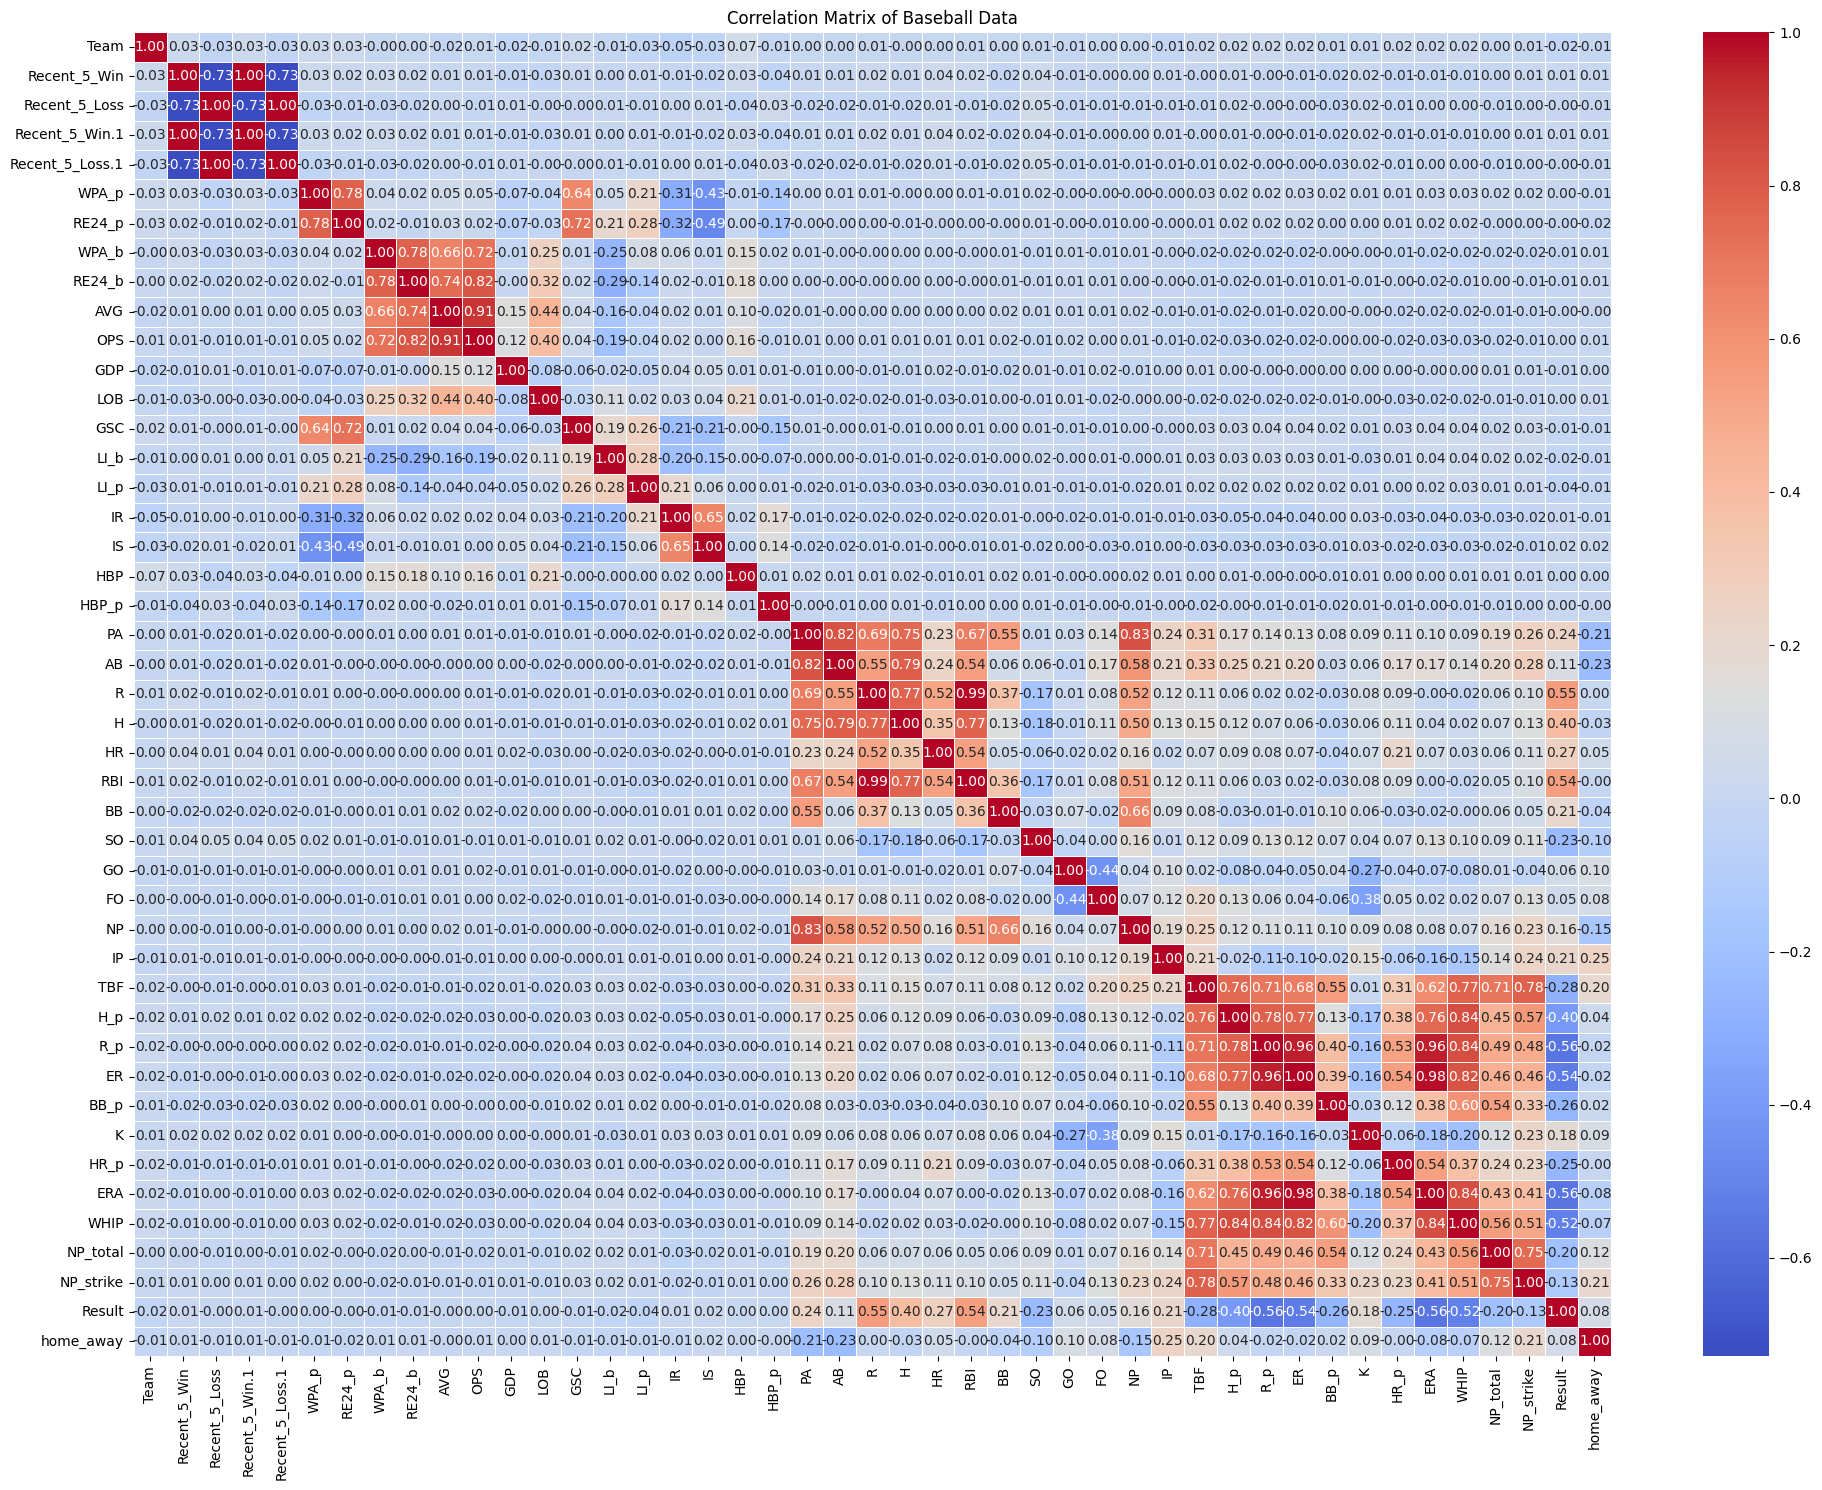

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# CSV 파일 불러오기
df = pd.read_csv('rolling_only.csv')

# 상관행렬 계산 (숫자형 데이터만)
correlation_matrix = df.corr(numeric_only=True)

# 히트맵 시각화
plt.figure(figsize=(20, 15))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix of Baseball Data')
plt.tight_layout()
plt.show()

In [2]:
pip install statsmodels

   ---------------------------------------- 0.0/9.8 MB ? eta -:--:--
   ---------------------------------------- 0.0/9.8 MB ? eta -:--:--
   ---------------------------------------- 0.1/9.8 MB 1.3 MB/s eta 0:00:08
   -- ------------------------------------- 0.6/9.8 MB 5.0 MB/s eta 0:00:02
   ---- ----------------------------------- 1.2/9.8 MB 7.0 MB/s eta 0:00:02
   ------ --------------------------------- 1.7/9.8 MB 7.6 MB/s eta 0:00:02
   --------- ------------------------------ 2.3/9.8 MB 8.5 MB/s eta 0:00:01
   ----------- ---------------------------- 2.8/9.8 MB 9.4 MB/s eta 0:00:01
   ------------- -------------------------- 3.3/9.8 MB 9.5 MB/s eta 0:00:01
   --------------- ------------------------ 3.8/9.8 MB 9.7 MB/s eta 0:00:01
   ----------------- ---------------------- 4.2/9.8 MB 9.6 MB/s eta 0:00:01
   ------------------- -------------------- 4.8/9.8 MB 10.2 MB/s eta 0:00:01
   --------------------- ------------------ 5.4/9.8 MB 10.1 MB/s eta 0:00:01
   ---------------------

In [11]:
import pandas as pd
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

# CSV 파일 불러오기
df = pd.read_csv('rolling_only.csv')

def calculate_vif(df):
    X = add_constant(df)
    vif = pd.DataFrame()
    vif["feature"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    return vif

# 1차: 전체 변수에 대해 VIF 계산
vif_1st = calculate_vif(numeric_df)
print("1차 VIF 결과:\n", vif_1st)

# VIF가 매우 높은 변수 제거 (예: VIF > 30)
cols_to_remove = vif_1st[vif_1st['VIF'] > 30]['feature'].tolist()
cols_to_remove = [col for col in cols_to_remove if col != 'const']  # const 제외

# 제거 후 남은 변수로 2차 VIF
numeric_df_2nd = numeric_df.drop(columns=cols_to_remove)
vif_2nd = calculate_vif(numeric_df_2nd)
print("\n2차 VIF 결과:\n", vif_2nd)

1차 VIF 결과:
           feature          VIF
0           const  3250.422732
1            Team     1.003348
2    Recent_5_Win     2.232767
3   Recent_5_Loss     2.234504
4              PA    22.731884
5              AB    11.830302
6               R    41.534241
7               H     8.372924
8              HR     1.618510
9             RBI    40.809910
10             BB     5.992030
11             SO     1.327960
12             GO     3.788485
13             FO     4.883046
14             NP     4.601047
15             IP     1.479118
16            TBF    21.393060
17            H_p    86.003114
18            R_p    17.700637
19             ER    55.090843
20           BB_p    36.291090
21              K     4.366957
22           HR_p     1.562852
23            ERA    66.888718
24           WHIP   111.175498
25       NP_total     3.005227
26      NP_strike     4.125622
27         Result     3.710251
28      home_away     2.743307

2차 VIF 결과:
           feature         VIF
0           con

In [ ]:
import pandas as pd

# 1. CSV 불러오기
df_total = pd.read_csv('../data/rolling_only.csv')  # ← 여기에 실제 파일명 입력


# 최근 5경기 승/패 전적 계산
recent_wins = []
recent_losses = []
match_history = {}

for i in range(0, len(df_total), 2):
    row1 = df_total.iloc[i]
    row2 = df_total.iloc[i + 1]

    t1, t2 = row1['Team'], row2['Team']
    key = tuple(sorted((t1, t2)))

    history = match_history.get(key, [])
    wins_t1 = history.count((t1, 1))
    wins_t2 = history.count((t2, 1))

    recent_wins.extend([wins_t1, wins_t2])
    recent_losses.extend([wins_t2, wins_t1])

    if row1['Result'] == 1:
        history.append((t1, 1))
    elif row2['Result'] == 1:
        history.append((t2, 1))

    match_history[key] = history[-5:]

df_total['Recent_5_Win'] = recent_wins
df_total['Recent_5_Loss'] = recent_losses

# 2. 최종 선택된 13개 변수만 선택
selected_columns = [
    'OPS', 'BB', 'HBP', 'SO',         # 타자 성과
    'ERA', 'BB_p', 'K', 'IR', 'IS', 'TBF',  # 투수 성과
    'Recent_5_Win', 'Recent_5_Loss',  # 최근 경기 흐름
    'home_away'                       # 홈/원정 정보
]

# 3. 해당 변수만 남기고 나머지 제거
df_selected = df_total[selected_columns].copy()

# 4. 결과를 새 파일로 저장
df.to_csv('../data/final_data.csv', index=False, encoding='utf-8-sig')  # ← 저장 파일명 지정

print("✅ 13개 변수 선택 및 저장 완료!")

✅ 13개 변수 선택 및 저장 완료!
